In [20]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

# do PCA (and projective PCA?)
# todo: for each name look at its PCA (make a colored graph for different components?)
# train projection from PCA space to classifier space?

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)
            

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [21]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 40
seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
#templates = [BABA_TEMPLATES[1]]
templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())
'''
patching_formats = [
    'AB A B\nAC A C', # 85, 
    #'AB A B\nCB C B', # 66
    #'AB B A\nAC C A', # 74
    #'AB B A\nCB B C' # 85
]
'''



data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)



In [28]:

from tqdm import tqdm
from functools import partial
from mamba_lens.input_dependent_hooks import clean_hooks
clean_hooks(model)
# attribution patching does the following:
#           [B]                               [B] 
#      [B,L]  [B,L,D]  edge            [B,L]  [B,L,D], edge     [B,L,D]  [B,L,D]   [B,L,D]
#   M( input,  diff , (i->j)) approx M( input, diff_0, (i->j)) + ((  diff - diff_0)*diff.grad(M(input, diff_0, (i->j)))).sum(dim=1).sum(dim=1)
# where M (input, diff, (i,j)) is the metric on the outputs of our model, where
# diff is applied to the edge (i,j) via
# layer_inputs_j = layer_inputs_j - layer_outputs_i + layer_outputs_corrupted_i
# layer_inputs is the inputs to the layer
# layer_outputs is the outputs that are added to the residual stream
# diff = -layer_outputs_i + layer_outputs_corrupted_i

# and diff_0 = 0 vector
# which diff_0 corresponds to doing no patch

# diff.grad(M(input, diff_0, (i->j)))
# is the gradient of diff when diff_0 is passed in


def normalized_logit_diff_metric(patched_logits, unpatched_logits, corrupted_logits, patched_correct, corrupted_correct, also_return_acc=False):
    B,L = patched_logits.size()

    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = unpatched_logits[torch.arange(B), patched_correct]
    A_logits_patched = patched_logits[torch.arange(B), patched_correct]
    A_logits_corrupted = corrupted_logits[torch.arange(B), patched_correct]

    B_logits_unpatched = unpatched_logits[torch.arange(B), corrupted_correct]
    B_logits_patched = patched_logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = corrupted_logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted
    res = torch.mean(normalized_diff)
    
    if also_return_acc:
        num_correct = A_logits_patched > B_logits_patched
        acc = torch.sum(num_correct)/B
        return res, acc
    else:
        return res


model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True
}

output_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]
torch.set_grad_enabled(False)
# forward passes to get unpatched and corrupted
unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2], names_filter=output_names, **model_kwargs)
corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2], names_filter=output_names, **model_kwargs)
B,L,V = unpatched_logits.size()
# get only the last token position (logit for next predicted token)
unpatched_logits = unpatched_logits[torch.arange(B), data.last_token_position[::2]]
corrupted_logits = corrupted_logits[torch.arange(B), data.last_token_position[1::2]]


# backward pass to compute grad of diff
torch.set_grad_enabled(True)
B,L,D = unpatched_layer_outputs[output_names[0]].size()
# really we should have a diff for every edge, but since every (0->5), (1->5), (2->5) etc. has the same grad we can just
# do one for each outgoing term
diffs = torch.zeros([model.cfg.n_layers, B,L,D], device=model.cfg.device)
for layer in range(model.cfg.n_layers):
    output_name = output_names[layer]
    # remove unpatched and add corrupted
    diffs[layer] = -unpatched_layer_outputs[output_name] + corrupted_layer_outputs[output_name]


for param in model.parameters():
    param.requires_grad = True

global alpha
def fwd_diff_hook(
    x,
    hook,
    layer,
    diffs):
    global alpha
    # sum over all previous diffs, this patches all previous layers
    patched = x + diffs[:layer].sum(dim=0)
    unpatched = x
    return alpha * patched + (1-alpha)*unpatched

# attributions[b,i,j] is the (i->j) edge attribution for batch b
attributions = torch.zeros([B, model.cfg.n_layers, model.cfg.n_layers], device=model.cfg.device)

def bwd_diff_hook(
    grad,
    hook,
    layer,
    diffs):
    # [N_upstream, B, L, E]
    upstream_diffs = diffs[:layer]
    # grad is [B,L,E]
    # [N_upstream, B]
    attr = (grad*upstream_diffs).sum(dim=-1).sum(dim=-1)
    # [B, N_upstream]
    attr = attr.T
    attributions[:,:layer,layer] += attr
clean_hooks(model)

input_names = [f'blocks.{i}.hook_layer_input' for i in range(model.cfg.n_layers)]
fwd_hooks = [(input_names[layer], partial(fwd_diff_hook, layer=layer, diffs=diffs)) for layer in range(model.cfg.n_layers)]
bwd_hooks = [(output_names[layer], partial(bwd_diff_hook, layer=layer, diffs=diffs)) for layer in range(model.cfg.n_layers)]
for fwd, bwd in zip(fwd_hooks, bwd_hooks):
    model.add_hook(*fwd, "fwd")
    model.add_hook(*bwd, "bwd")

ITERS = 30
for i in range(ITERS):
    global alpha
    alpha = i/float(ITERS-1)    
    logits = model(data.data[::2], **model_kwargs)
    logits = logits[torch.arange(B), data.last_token_position[::2]]
    metric = normalized_logit_diff_metric(
        patched_logits=logits,
        unpatched_logits=unpatched_logits,
        corrupted_logits=corrupted_logits,
        patched_correct=data.correct[::2][:,0],
        corrupted_correct=data.correct[1::2][:,0]
    )
    print(f"alpha {alpha} metric {metric}")
    # run backward pass
    metric.backward()

attributions[:,:layer,layer] = attributions[:,:layer,layer]/ITERS
# don't need grad for rest of this
torch.set_grad_enabled(False)
clean_hooks(model)
'''
# now compute the attributions:
attributions = torch.zeros([B, model.cfg.n_layers, model.cfg.n_layers], device=model.cfg.device)
for i in tqdm(range(model.cfg.n_layers)):
    for j in range(i+1, model.cfg.n_layers):
        #   M( input,  diff , (i->j)) approx M( input, diff_0, (i->j)) + ((  diff - diff_0)*diff.grad(M(input, diff_0, (i->j)))).sum(dim=1).sum(dim=1)
        # [B,L,D]
        diff = -unpatched_layer_outputs[output_names[i]] + corrupted_layer_outputs[output_names[i]]
        # [B,L,D]
        grad = diff_tensors[j].grad
        print(i, j, torch.linalg.norm(diff.flatten(), ord=2), torch.linalg.norm(grad.flatten(), ord=2))
        # diff_0 is zero so we omit that here
        element_wise_prod = diff*grad
        attr = element_wise_prod.sum(dim=1).sum(dim=1)
        attributions[:,i,j] = attr

'''
    

# we can compute 
# layer_outputs_corrupted_i
# via a forward pass





# we can compute
# M( input, diff_0, (i->j))
# -layer_outputs_i
# and
# diff.grad(M(input, diff_0, (i->j)))
# via a single forward and backwqard pass









# 1. Get 

# to do edge-based attribution patching






alpha 0.0 metric 1.0
alpha 0.034482758620689655 metric 0.9683998227119446
alpha 0.06896551724137931 metric 0.9311980605125427
alpha 0.10344827586206896 metric 0.8875111937522888
alpha 0.13793103448275862 metric 0.8363868594169617
alpha 0.1724137931034483 metric 0.7770761847496033
alpha 0.20689655172413793 metric 0.7097341418266296
alpha 0.2413793103448276 metric 0.6361872553825378
alpha 0.27586206896551724 metric 0.5599803924560547
alpha 0.3103448275862069 metric 0.4852607250213623
alpha 0.3448275862068966 metric 0.4149162471294403
alpha 0.3793103448275862 metric 0.3508467674255371
alpha 0.41379310344827586 metric 0.29382941126823425
alpha 0.4482758620689655 metric 0.24389110505580902
alpha 0.4827586206896552 metric 0.20066308975219727
alpha 0.5172413793103449 metric 0.16343660652637482
alpha 0.5517241379310345 metric 0.13150185346603394
alpha 0.5862068965517241 metric 0.10421440750360489
alpha 0.6206896551724138 metric 0.0810423493385315
alpha 0.6551724137931034 metric 0.0615109466016

'\n# now compute the attributions:\nattributions = torch.zeros([B, model.cfg.n_layers, model.cfg.n_layers], device=model.cfg.device)\nfor i in tqdm(range(model.cfg.n_layers)):\n    for j in range(i+1, model.cfg.n_layers):\n        #   M( input,  diff , (i->j)) approx M( input, diff_0, (i->j)) + ((  diff - diff_0)*diff.grad(M(input, diff_0, (i->j)))).sum(dim=1).sum(dim=1)\n        # [B,L,D]\n        diff = -unpatched_layer_outputs[output_names[i]] + corrupted_layer_outputs[output_names[i]]\n        # [B,L,D]\n        grad = diff_tensors[j].grad\n        print(i, j, torch.linalg.norm(diff.flatten(), ord=2), torch.linalg.norm(grad.flatten(), ord=2))\n        # diff_0 is zero so we omit that here\n        element_wise_prod = diff*grad\n        attr = element_wise_prod.sum(dim=1).sum(dim=1)\n        attributions[:,i,j] = attr\n\n'

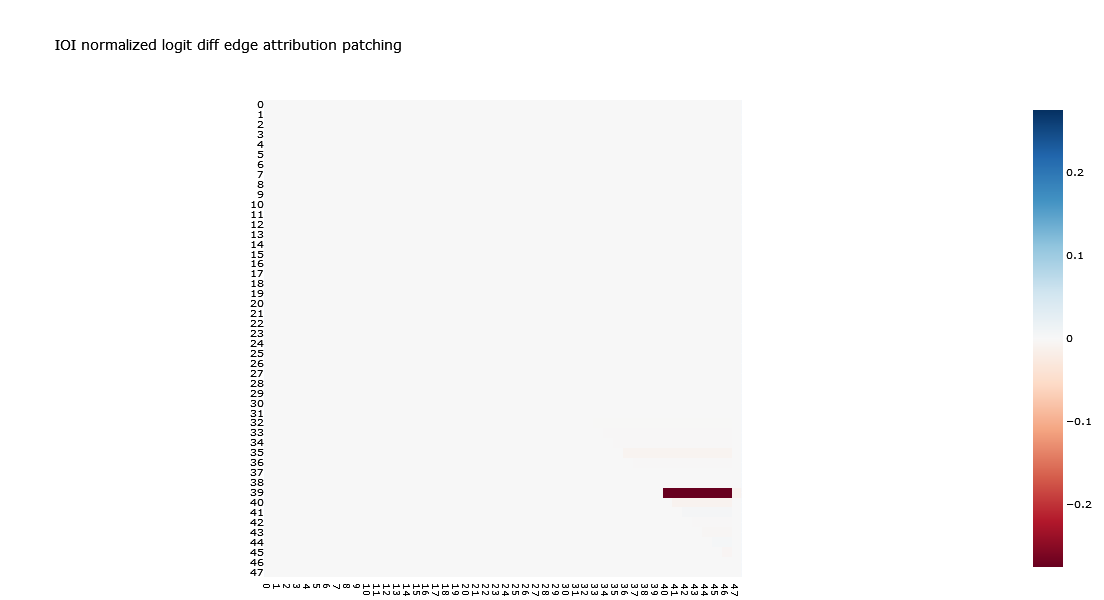

In [29]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig


layer_names = list(map(str, range(model.cfg.n_layers)))
imshow(attributions.mean(dim=0), x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='IOI normalized logit diff edge attribution patching')

In [33]:
from functools import partial

def test_graph(keeping_edges):
    edges_patching = []
    keeping_edges_set = set(keeping_edges)
    for i in range(model.cfg.n_layers):
        for j in range(i+1, model.cfg.n_layers):
            edge = (i,j)
            if not edge in keeping_edges_set:
                edges_patching.append(edge)

    storage = {}
    clean_hooks(model)
    unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[0::2], names_filter=output_names, **model_kwargs)
    corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2], names_filter=output_names, **model_kwargs)
    # get only the last token position (logit for next predicted token)
    unpatched_logits = unpatched_logits[torch.arange(B), data.last_token_position[::2]]
    corrupted_logits = corrupted_logits[torch.arange(B), data.last_token_position[1::2]]
  
    def patching_hook(
        x,
        hook,
        edge_input_hook):
        return x - unpatched_layer_outputs[edge_input_hook] + corrupted_layer_outputs[edge_input_hook]

    hooks = []
    for input_layer, output_layer in edges_patching:
        hooks.append((f'blocks.{output_layer}.hook_layer_input', partial(patching_hook, edge_input_hook=f'blocks.{input_layer}.hook_out_proj')))

    patched_logits = model.run_with_hooks(data.data[::2], fwd_hooks=hooks, **model_kwargs)
    # get only the last token position (logit for next predicted token)
    patched_logits = patched_logits[torch.arange(B), data.last_token_position[::2]]
    
    metric, acc = normalized_logit_diff_metric(
        patched_logits=patched_logits,
        unpatched_logits=unpatched_logits,
        corrupted_logits=corrupted_logits,
        patched_correct=data.correct[::2][:,0],
        corrupted_correct=data.correct[1::2][:,0],
        also_return_acc=True
    )


        
    print(f"got metric {metric} and acc {acc} when patched")


attrs = attributions.mean(dim=0)
edges = []
for i in range(model.cfg.n_layers):
    for j in range(i+1, model.cfg.n_layers):
        edges.append((attrs[i,j], i, j))
edges.sort(key=lambda x: x[0])

edges_to_keep = []
for i in range(0, len(edges), 20):
    score, layer_input, layer_output = edges[i]
    if i == 20:
        for h in edges[:i]:
            print(h)
    edges_to_keep = [(in_edge,out_edge) for (score, in_edge, out_edge) in edges[:i]]
    print(f"keeping top {i} edges")
    test_graph(edges_to_keep)


keeping top 0 edges
got metric -0.011293632909655571 and acc 0.02500000037252903 when patched
(tensor(-0.2754, device='cuda:0'), 39, 40)
(tensor(-0.2754, device='cuda:0'), 39, 41)
(tensor(-0.2754, device='cuda:0'), 39, 42)
(tensor(-0.2754, device='cuda:0'), 39, 43)
(tensor(-0.2754, device='cuda:0'), 39, 44)
(tensor(-0.2754, device='cuda:0'), 39, 45)
(tensor(-0.2754, device='cuda:0'), 39, 46)
(tensor(-0.0092, device='cuda:0'), 40, 41)
(tensor(-0.0092, device='cuda:0'), 40, 42)
(tensor(-0.0092, device='cuda:0'), 40, 43)
(tensor(-0.0092, device='cuda:0'), 40, 44)
(tensor(-0.0092, device='cuda:0'), 40, 45)
(tensor(-0.0092, device='cuda:0'), 40, 46)
(tensor(-0.0092, device='cuda:0'), 39, 47)
(tensor(-0.0084, device='cuda:0'), 35, 36)
(tensor(-0.0084, device='cuda:0'), 35, 37)
(tensor(-0.0084, device='cuda:0'), 35, 38)
(tensor(-0.0084, device='cuda:0'), 35, 39)
(tensor(-0.0084, device='cuda:0'), 35, 40)
(tensor(-0.0084, device='cuda:0'), 35, 41)
keeping top 20 edges
got metric 0.008072915486

KeyboardInterrupt: 